# Part 1 : Exploratory Data Analysis

In [269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates
import seaborn as sns
from matplotlib.dates import DateFormatter
from matplotlib.dates import HourLocator,MinuteLocator
from datetime import datetime, timedelta
from dateutil import parser
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = pd.read_json("E:datasets/ultimate_challenge/logins.json",convert_dates=True)
data.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
data = data.set_index('login_time')

In [5]:
data.head()

""
login_time
1970-01-01 20:13:18
1970-01-01 20:16:10
1970-01-01 20:16:37
1970-01-01 20:16:36
1970-01-01 20:26:21


In [6]:
data['values'] = 1
data1 = data.resample('15T').sum()

In [8]:
data1.head(5)

,values
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


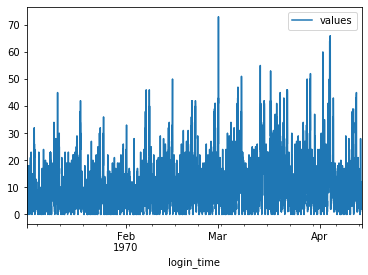

In [179]:
data1.plot()

In [9]:
data=data1.reset_index()

In [10]:
data

,login_time,values
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1
...,...,...
9783,1970-04-13 17:45:00,5
9784,1970-04-13 18:00:00,5
9785,1970-04-13 18:15:00,2
9786,1970-04-13 18:30:00,7


In [11]:
data["Month"]=data["login_time"].apply(lambda X:X.month)
data["DayOfWeek"]=data["login_time"].apply(lambda X:X.strftime('%A'))
data["time_day"]=data.login_time.astype('str').apply(lambda x:x.split(' ')[1])

In [59]:
data.head()

,login_time,values,Month,DayOfWeek,time_day
0,1970-01-01 20:00:00,2,1,Thursday,20:00:00
1,1970-01-01 20:15:00,6,1,Thursday,20:15:00
2,1970-01-01 20:30:00,9,1,Thursday,20:30:00
3,1970-01-01 20:45:00,7,1,Thursday,20:45:00
4,1970-01-01 21:00:00,1,1,Thursday,21:00:00


In [87]:
time_avg_df=data[['time_day','values']].groupby(['time_day']).mean()

In [92]:
time_avg_df.columns

Index(['values'], dtype='object')

In [95]:
plot_1 = data[['time_day','values']].groupby(['time_day']).mean()


In [171]:
plot_2 = data[['DayOfWeek','values']].groupby(['DayOfWeek']).mean()

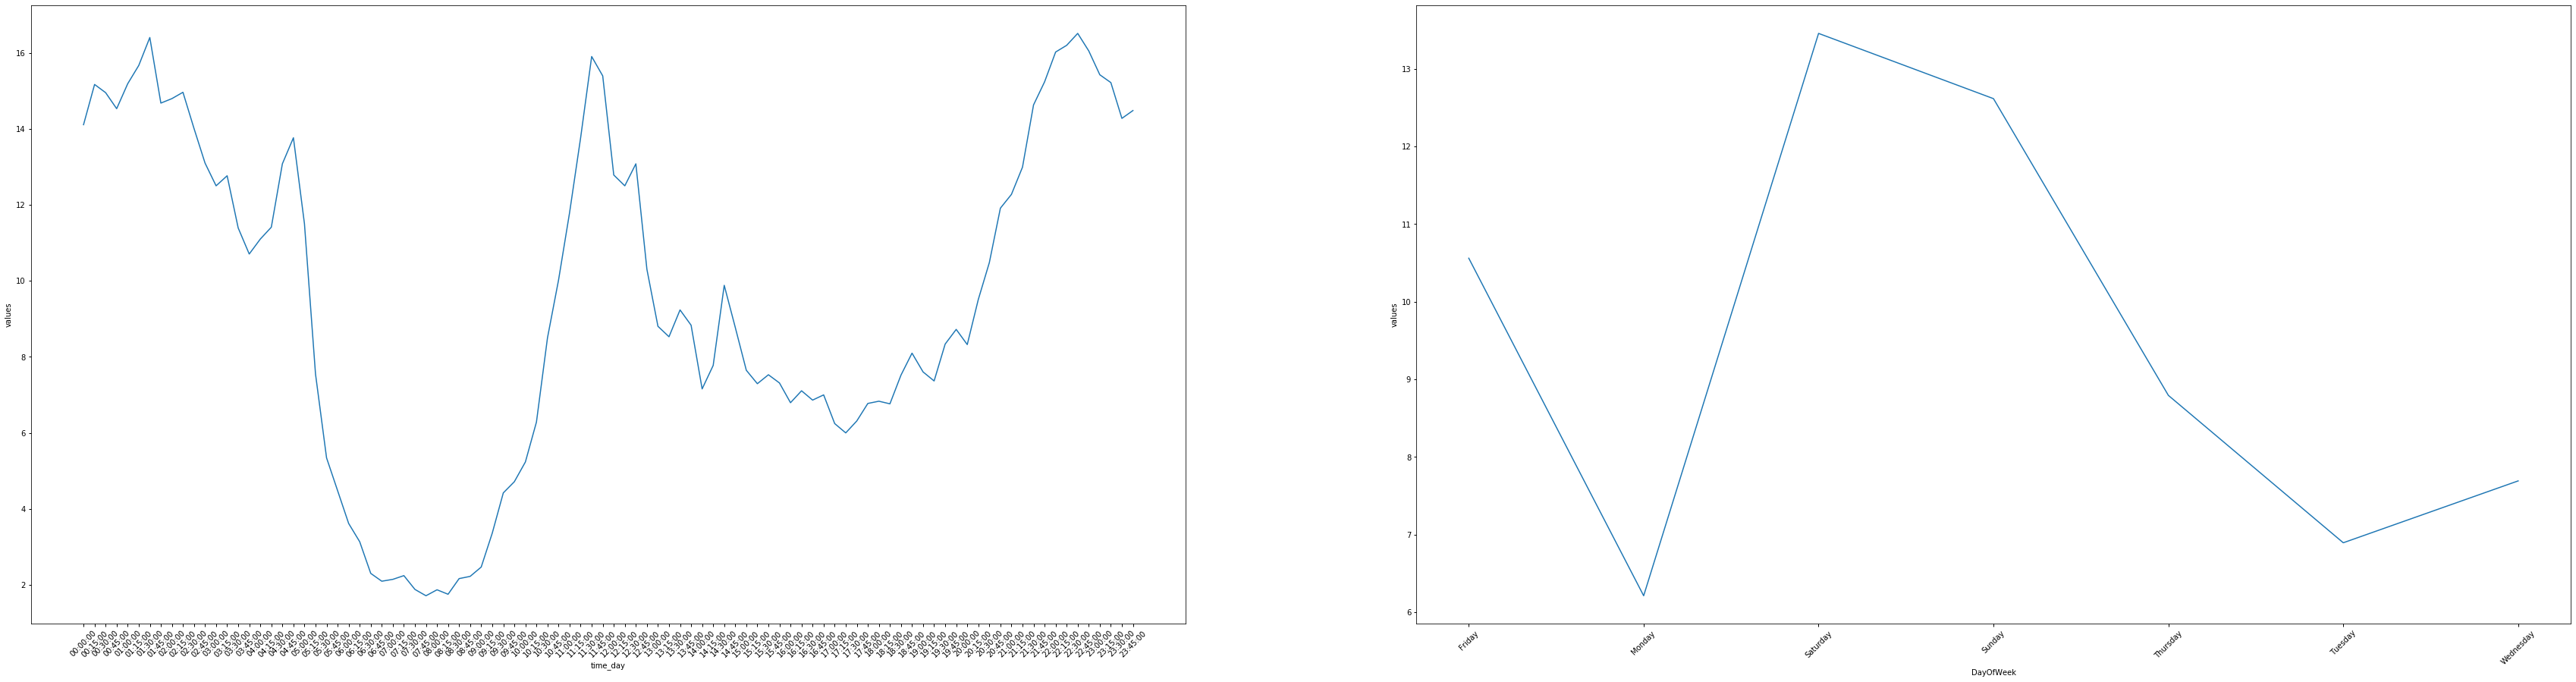

In [204]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(60,15));
ax1.set(xlabel='time_day', ylabel='values');
ax1.tick_params(axis='x',rotation=45)
ax1.tick_params(which='major',width=1.00)
ax1.plot(plot_1);

ax2.set(xlabel='DayOfWeek', ylabel='values');
ax2.tick_params(axis='x',rotation=45)
ax2.tick_params(which='major',width=1.00)
ax2.plot(plot_2);

#### plot1: 
Morning and evening have lowest user logins.
Logins pick up around 9 AM (possible: rush hour to work) and peak right before noon (possible: rush hour to lunch).
Then they drop off, although they may pick up slightly before midnight (possible: returning from "going out" hours).
#### plot 2 :
Logins pick up during weekends.

# Part 2: Experiment and metrics design

##### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

##### 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:


# Part 3: Predictive modeling

### 1. Data cleaning, exploratory analysis, visualizations

In [293]:
data2 = pd.read_json("E:datasets/ultimate_challenge/ultimate_data_challenge.json",convert_dates=True)

In [294]:
data2.tail()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
49995,King's Landing,0,2014-01-25,5.0,1.0,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.0,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.0,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5
49999,Astapor,0,2014-01-18,NaN,1.0,2014-04-20,Android,0.0,False,0.0,3.49,5.0


In [295]:
data2["daysDiff"]=data2.last_trip_date.apply(lambda x:(datetime.strptime(data2.last_trip_date.max(), "%Y-%m-%d")-datetime.strptime(x, "%Y-%m-%d")).days)

In [296]:
df_retained =  data2.loc[data2.daysDiff<=31]

In [297]:
print("Fraction of observed users retained: ", len(df_retained) / len(data2))

Fraction of observed users retained:  0.38446


### 2. Build a predictive model

In [298]:
date_last  = pd.to_datetime(data2.last_trip_date)

In [299]:
# Set up
data2['signup_date'] = pd.to_datetime(data2['signup_date']) # convert dates to datetime objects
month_6 = data2['signup_date'] + timedelta(days=151) # set minimum date of last ride to qualitfy as "active in their 6th mo"

# Get users active in their 6th month in system
active_idx = [idx for idx, s in enumerate(date_last) if s > month_6[idx]] # their their indices in database

# Append data to our database (useful for data viz later)
data2['active'] = 0 # set default to 0
data2.loc[active_idx, 'active'] = 1 # set active users to 1

print("Number of active users: ", len(active_idx))
print("Number of inactive users: ", len(data2) - len(active_idx))
print("Percent active users: ", len(active_idx)/len(data2))

Number of active users:  11694
Number of inactive users:  38306
Percent active users:  0.23388


#### 2.1 Data cleaning, preprocessing, & EDA

In [300]:
#Check number of unique values in each of the columns.
print("city: ", data2['city'].unique())
print("phone: ", data2['phone'].unique())
print("ultimate_black_user: ", data2['ultimate_black_user'].unique())

city:  ["King's Landing" 'Astapor' 'Winterfell']
phone:  ['iPhone' 'Android' None]
ultimate_black_user:  [ True False]


In [301]:
#Convert columns w/ string values to int
# Convert cities
cities = {'Winterfell': 1, 'Astapor': 2, "King's Landing": 3}
data2['city'] = data2['city'].map(lambda x: cities[x])

# Convert phones
phones = {"iPhone": 1, "Android": 2}
data2['phone'] = data2['phone'].map(lambda i: phones[i] if i is not None else 0)

# Convert ultimate black status
data2['ultimate_black_user'] = data2['ultimate_black_user'].map(lambda b: 1 if b == True else 0)

In [302]:
#Replace missing values
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  int64         
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  object        
 6   phone                   50000 non-null  int64         
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  int64         
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  daysDiff                50000 non-null  int64 

In [303]:
data2['avg_rating_by_driver'].fillna(data2['avg_rating_by_driver'].mean(), inplace=True)
data2['avg_rating_of_driver'].fillna(data2['avg_rating_of_driver'].mean(), inplace=True)

In [304]:
data2.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,daysDiff,active
0,3,4,2014-01-25,4.7,1.10,2014-06-17,1,15.4,1,46.2,3.67,5.0,14,0
1,2,0,2014-01-29,5.0,1.00,2014-05-05,2,0.0,0,50.0,8.26,5.0,57,0
2,2,3,2014-01-06,4.3,1.00,2014-01-07,1,0.0,0,100.0,0.77,5.0,175,0
3,3,9,2014-01-10,4.6,1.14,2014-06-29,1,20.0,1,80.0,2.36,4.9,2,1
4,1,14,2014-01-27,4.4,1.19,2014-03-15,2,11.8,0,82.4,3.13,4.9,108,0


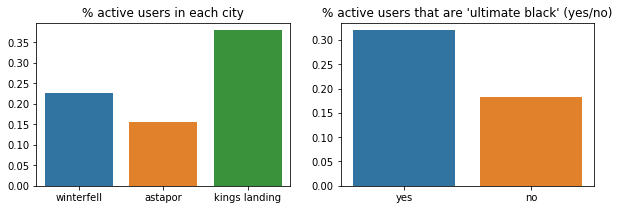

In [305]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

# % active users by city

df1 = data2[data2['city']==1]
df2 = data2[data2['city']==2]
df3 = data2[data2['city']==3]

active1 = len(df1[df1['active']==1])/len(df1)
active2 = len(df2[df2['active']==1])/len(df2)
active3 = len(df3[df3['active']==1])/len(df3)

g = sns.barplot(x = ['winterfell', 'astapor', 'kings landing'], y = [active1, active2, active3], ax=ax1);
g.set_title('% active users in each city');

# % active users by "ultimate black" status

df1 = data2[data2['ultimate_black_user']==1]
df2 = data2[data2['ultimate_black_user']==0]

active1 = len(df1[df1['active']==1])/len(df1)
active2 = len(df2[df2['active']==1])/len(df2)

g = sns.barplot(x = ['yes', 'no'], y = [active1, active2], ax=ax2);
g.set_title("% active users that are 'ultimate black' (yes/no)");

In [306]:
data2.drop(['surge_pct', 'avg_surge', 'phone', 'last_trip_date', 'signup_date','daysDiff'], inplace=True, axis=1)

In [307]:
data2.head()

,city,trips_in_first_30_days,avg_rating_of_driver,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,3,4,4.7,1,46.2,3.67,5.0,0
1,2,0,5.0,0,50.0,8.26,5.0,0
2,2,3,4.3,0,100.0,0.77,5.0,0
3,3,9,4.6,1,80.0,2.36,4.9,1
4,1,14,4.4,0,82.4,3.13,4.9,0


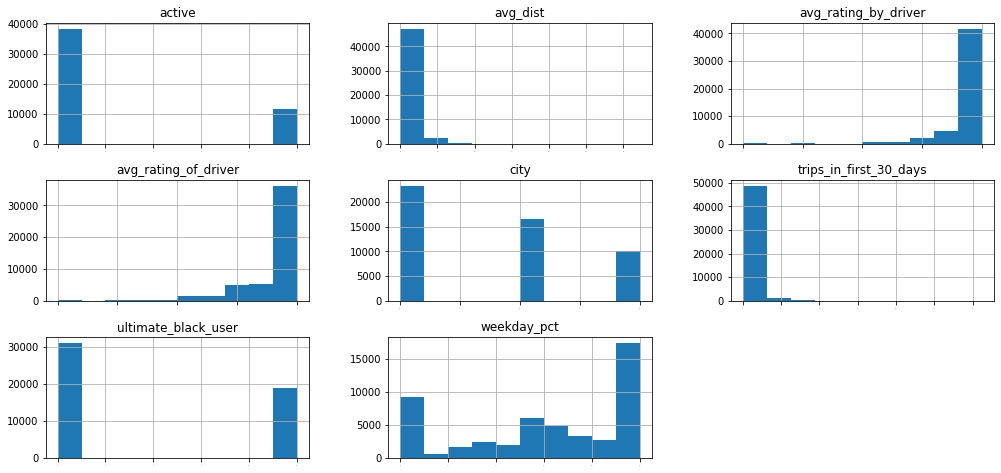

In [308]:
data2.hist(sharex=False, sharey=False, xlabelsize=1, figsize=(17,8));

In [309]:
from sklearn.preprocessing import MinMaxScaler

x = data2.drop('active', axis=1)
y = data2['active']

scaler = MinMaxScaler()
scaler.fit(x)
x = scaler.fit_transform(x)

In [310]:
X_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

745 of churners were incorrectly labeled as 'active' users. There are also many active users misclassified as churners (false negatives, 3280). Let's move on to the other ML approaches to see how they compare.

In [311]:
from sklearn.naive_bayes import MultinomialNB

# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(X_train, y_train)

# Create the predicted tags: pred
y_true, y_pred = y_test, nb_classifier.predict(x_test)

print(confusion_matrix(y_true, y_pred))

[[11501     0]
 [ 3499     0]]


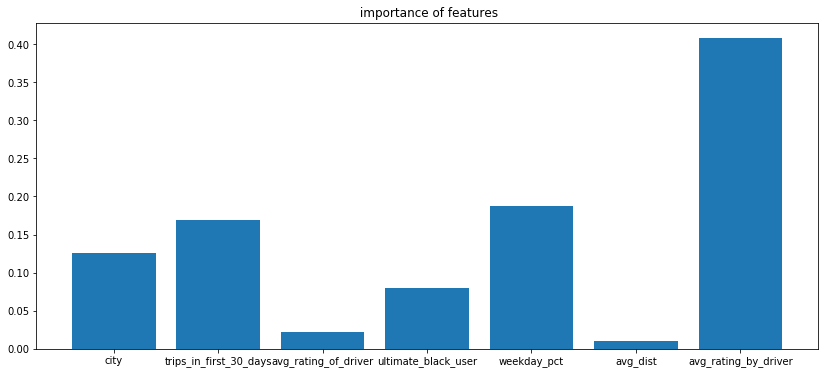

In [316]:
model = RandomForestClassifier(max_depth=4, min_samples_split=100, n_estimators=30, random_state=42)
model.fit(X_train, y_train)
y_true, y_pred = y_test, model.predict(x_test)

# Plot importance of features
plt.figure(figsize=(14,6));
plt.bar(data2.columns[:-1].tolist(), model.feature_importances_);
plt.title('Importance of features');

Most important features appear to be average rating by driver and % of user's trips occurring during weekday.

##### 2.2.4 Results
Approach. Ultimate's goal is to predict rider retention. Presumably this means they would like to predict users at risk for churn and target them for marketing campaigns, discounts, getting in touch, etc. that would retain these users.

As a result, our model emphasizes minimizing false positives (churned users misclassified as 'active' and thus missed by marketing campaigns, etc), while balancing a reasonable amount of false negatives ('active' users misclassified as churners who would then get spammed with these marketing campaigns).
Predicting churned users. Our model is a Random Forest Classifier, with {'max_depth': 4, 'min_samples_split': 100, 'n_estimators': 30}. This model does a good job of predicting churned users, with only 1.3% of churners being misclassified as 'active'.

The cost is that 21.4% of active users are misclassified as churners, which means they could receive marketing targeted towards churners. However, if this does not result in active users churning (presumably Ultimate adds value sufficiently that they are active users), then this is not necessarily an issue.
Still, Ultimate should do further tests to determine how detrimental these false negatives are - will active users necessarily churn because they receive ads as well? And at what frequency of ads would active users begin to churn? A balance can probably be struck.

### 2.3 Discussion
How should Ultimate leverage these insights to improve its longterm rider retention?

The features that were most predictive of 'active'/'inactive' were average rating by driver</i> and percent of user's trips occurring during weekday</i>. As a result, our further recommendations to Ultimate are:

Promote positive driver-rider interaction. It seems lower average rating by driver --> more risk for rider churning. Riders probably had dissatisfactory experiences. Encourage drivers to offer amenities that don't cost them much, such as water, candy, etc. Encourage them to ask a basic set of questions to improve rider mood/reduce likelihood of bad driver interaction, such as offering to roll down window, asking about AC, music, etc. Thus, average rating by driver may improve, resulting in less churning.

Target churners with weekday discounts. From our analysis, percent of user's trips during weekday is important predictor of churning. Increasing churners' weekday trips may therefore improve likelihood of them remaining customers. This could be accomplished by offering them weekday discounts for their Ultimate trips, making Ultimate more of a weekday routine for them and therefore increasing the likelihood they will remain active users.

Extend weekday discounts for "worst" churners. Even if some churners only "stay" as long as there is a weekly discount, if Ultimate is not losing money on these customers that would otherwise not use their service and are price-sensitive, it may be useful to extend these discounts for select churners. We recommend Ultimate to identify the most price-sensitive churners.